<html>
<table style="width:100%" align="center" border="0px white">
<tr></td>
<td><a href="https://colab.research.google.com/github/UCL-EO/uclgeog_msc_core/blob/master/NASA.ipynb">
         <img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg">
</a>
<td><a href="https://mybinder.org/v2/gh/UCL-EO/uclgeog_msc_core/master">
         <img alt="Binder" src="https://mybinder.org/badge_logo.svg">
</a></td>                               
<td><a href="https://github.com/UCL-EO/uclgeog_msc_core/blob/master/NASA.ipynb">
         <img alt="View in github" src="https://img.shields.io/static/v1?logo=github&label=View%20in&message=github&color=green">
</a></td>    
<td><a href="https://nbviewer.jupyter.org/github/UCL-EO/uclgeog_msc_core/blob/master/NASA.ipynb">
         <img alt="View in nbviewer" src="https://img.shields.io/static/v1?logo=jupyter&label=View%20in&message=nbviewer&color=blue">
</a></td>    
    </tr>
    </table>
    
<img alt="UCL" src="images/ucl_logo.png">
</html>

# NASA MODIS Earthdata


## Introduction

### Purpose 

In this notebook, we will use high-level codes from `uclgeog_msc_core` for downloading and interpreting NASA MODIS datasets from [`NASA EarthData`](https://urs.earthdata.nasa.gov). Wew will also be visualising these data in this notebook.

We will be **introducing NASA MODIS land products**, and viewing the MODIS LAI product as an example. This notebook should serve as an introduction to accessing similar products from Earthdata.

The aim of the codes here is not to provide an exhaustive interface to MODIS data products, although the same scripts should be useable for most, if not all similar products. Rather, it is to use these high-level codes to easily access and visualise the data to understand their properties. 

Neither is it to develop or use an [API](https://en.wikipedia.org/wiki/Application_programming_interface) to access the data. If all you want is to get hold of some data product for some defined location and time, then you might use an API such as [Appeears](https://lpdaacsvc.cr.usgs.gov/appeears/).

Students who take the [GEOG0111 course](https://github.com/profLewis/newform0111) will develop codes along similar lines to this later in the term, so for them, these notes also illustrate some of the things they will be able to do when you have finished this course. For them, we will *look under the bonnet* of such codes, and learn how to develop them. For others, they can use these codes as they stand to access MODIS data via Earthdata.

### Prerequisites

Before you can use the material in this notebook, you will need to register as a user at the [`NASA EarthData`](https://urs.earthdata.nasa.gov/users/new).

Once you have done that, make sure you know your `username` and `password` ready for below.

The are no assumptions that you know any python code at this point: the use of code is high enough level that it should be easily understood by all.

We do assume that you have basic familiarity with using [Jupyter notebooks](notebook.ipynb).

You should run through the [Credentials](#Credentials) section below before proceeding further with these notes.

### Credentials

We will store your credentials for [`NASA EarthData`] (https://urs.earthdata.nasa.gov/users/new) to allow easier data downloading. 

**N.B. using `cylog().login()` is only intended to work with access to NASA Earthdata and to prevent you having to expose your username and password in these notes**.


In the `uclgeog_msc_core` library, we have a Python class called `cylog`, written to allow easier persistent interface to NASA download servers.

First, we import `cylog` from the `uclgeog_msc_core` library.

Run the cell below:

In [ ]:
try:
    from uclgeog_msc.cylog import cylog
    from uclgeog_msc.nasa_requests import test
except:
    raise SystemExit("Error loading the required uclgeog_msc library")

If this gave an error, there is a problem importing the `uclgeog_msc_core` library and you shoiuld get help on this in a support class.

### Earthdata login

Run the cell below, and enter your `username` and `password` if prompted.

In [ ]:
cy = cylog()

# run a test
print('Did I pass?',test())

If you want to force the code to let you re-enter your credentials (e.g. you got it wrong before, or have changed them, or the test fails), then change the call to:

    cy = cylog(init=True)
    
and re-run.

`cylog` stores your username and password in a file that only you can read. We can use this as a convenient way to pull some NASA MODIS data.

## MODIS LAI product 

To introduce geospatial processing, we will use a dataset from the MODIS LAI product over the UK. 

The data product [MOD15](https://modis.gsfc.nasa.gov/data/dataprod/mod15.php) LAI/FPAR has been generated from NASA MODIS sensors Terra and Aqua data since 2002. We are now in dataset collection 6 (the data version to use).

    LAI is defined as the one-sided green leaf area per unit ground area in broadleaf canopies and as half the total needle surface area per unit ground area in coniferous canopies. FPAR is the fraction of photosynthetically active radiation (400-700 nm) absorbed by green vegetation. Both variables are used for calculating surface photosynthesis, evapotranspiration, and net primary production, which in turn are used to calculate terrestrial energy, carbon, water cycle processes, and biogeochemistry of vegetation. Algorithm refinements have improved quality of retrievals and consistency with field measurements over all biomes, with a focus on woody vegetation.
    
We use such data to map and understand about the dynamics of terrestrial vegetation / carbon, for example, for climate studies.

The raster data are arranged in tiles, indexed by row and column, to cover the globe:


![MODIS tiles](https://www.researchgate.net/profile/J_Townshend/publication/220473201/figure/fig5/AS:277546596880390@1443183673583/The-global-MODIS-Sinusoidal-tile-grid.png)


### Exercise

The pattern on the tile names is `hXXvYY` where `XX` is the horizontal coordinate and `YY` the vertical.


* use the map above to work out the names of the two tiles that we will need to access data over the UK
* set the variable `tiles` to contain these two names in a list

For example, for the two tiles covering Madagascar, we would set:

    tiles = ['h22v10','h22v11']

In [ ]:
# tiles for the UK

tiles = ['h17v03', 'h17v04', 'h18v03', 'h18v04']


### Accessing NASA MODIS URLs

<span class="burk">**Warning: The NASA data servers tend to be down for maintainance on Wednesday morning EST**</span>

Although you can access MODIS datasets through the [NASA Earthdata](https://urs.earthdata.nasa.gov/home) interface, there are many occasions that we would want to just automatically pull datasets. As we note above, we could use some existing API for this, such as [Appeears](https://lpdaacsvc.cr.usgs.gov/appeears/), but we are aiming here at being able to ultimately develop codes that do this from a lower-level perspective. 

Automation has many roles, and is particularly useful when you want a time series of data that might involve many files. For example, for analysing LAI or other variables over space/time) we will want to write code that pulls the time series of data. 

If you visit the site [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006), you will see 'date' style links (e.g. `2018.09.30`) through to sub-directories. 

In these, e.g. [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/) you will find URLs of a set of files. 

The files pointed to by the URLs are the MODIS MOD15 4-day composite 500 m LAI/FPAR product [MCD15A3H](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a3h_v006).

There are links to several datasets on the page, including 'quicklook files' that are jpeg format images of the datasets, e.g.:

![MCD15A3H.A2018273.h17v03](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/BROWSE.MCD15A3H.A2018273.h17v03.006.2018278143630.1.jpg)

as well as `xml` files and `hdf` datasets. 



### Data Products

If we look at the dataserver we hae specified [https://e4ftl01.cr.usgs.gov](https://e4ftl01.cr.usgs.gov), we will see that a number of sub-directories exist. Each of these 'server directories' points to a different data stream:

    [DIR] ASTT/                   2019-08-05 07:54    -   
    [DIR] COMMUNITY/              2020-06-02 08:45    -   
    [DIR] ECOSTRESS/              2020-04-09 10:30    -   
    [DIR] GEDI/                   2020-02-10 09:58    -   
    [DIR] MEASURES/               2020-03-17 10:55    -   
    [DIR] MOLA/                   2020-06-01 09:20    -   
    [DIR] MOLT/                   2020-04-14 08:06    -   
    [DIR] MOTA/                   2019-12-27 06:49    -   
    [DIR] VIIRS/                  2020-06-23 10:26    -   

For example, we might notice [VIIRS](https://e4ftl01.cr.usgs.gov/VIIRS) which takes us to the [VIIRS data products](https://viirsland.gsfc.nasa.gov), or [GEDI](https://e4ftl01.cr.usgs.gov/GEDI) [spaceborne lidar](https://gedi.umd.edu/) data. Each of these data streams will have their own properties that we need to appreciate before using them.

### MOTA

The URL we have used above, [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/) starts with a call to the server directory `MOTA`, so we can think of `https://e4ftl01.cr.usgs.gov/MOTA` as the base level URL.

MOTA refers to combined MODIS Terra and Aqua datasets. Similarly, MOLA and MOLT refer to datasets generated from single MODIS sensors of Aqua and Terra, respectively.

The rest of the directory information `MCD15A3H.006/2018.09.30` tells us:

* the product name `MCD15A3H`
* the product version `006`
* the date of the dataset `2018.09.30`

There are several ways we could specify the date information. The most 'human readable' is probably `YYYY.MM.DD` as given here. 

### MODIS filename format

If we vist the link to a particular date for this dataset  [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/), we see some files that have the suffix `hdf`.

The `hdf` filenames are of the form:

    MCD15A3H.A2018273.h35v10.006.2018278143650.hdf
    
where:

* the first field (`MCD15A3H`) gives the product code
* the second (`A2018273`) gives the observation date: day of year `273`, `2018` here
* the third (`h35v10`) gives the 'MODIS tile' code for the data location
* the remaining fields specify the product version number (`006`) and a code representing the processing date.

If we look at the [product specification page](https://lpdaac.usgs.gov/products/mcd15a3hv006/) we see that the data product has multiple data layers. In the case of MCD15A3H, this is:

|SDS Name	|Description	| Units	|Data Type	|Fill Value|	No Data Value	|Valid Range|	Scale Factor
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|-|
| Fpar_500m |	Fraction of Photosynthetically Active Radiation	|Percent|	8-bit unsigned integer	|249 to 255	|N/A	|0 to 100	|0.01
|Lai_500m	|Leaf Area Index|	m²/m²|	8-bit unsigned integer|	249 to 255	|N/A|	0 to 100|	0.1|
|FparLai_QC	|Quality for  FPAR and LAI	|Class Flag	|8-bit unsigned integer	|255|	N/A	|0 to 254	|N/A
| FparExtra_QC	|Extra detail Quality for  FPAR and LAI	|Class Flag|	8-bit unsigned integer|	255	|N/A	|0 to 254	|N/A
|FparStdDev_500m|	Standard deviation of  FPAR	|Percent|	8-bit unsigned integer|	248 to 255	|N/A|	0 to 100	|0.01
|LaiStdDev_500m|	Standard deviation of LAI	|m²/m²|	8-bit unsigned integer|	248 to 255|	N/A	|0 to 100	|0.1


## Getting and visualising the data

### Grid

One thing we might need sometimes is to specify the `grid` used by the data product. Mostly, this is just the same as the product name (this is the default in our codes by just setting `grid` to the same as the product name). 

For the product `MCD15A3H` that we use here though, the grid is `MOD_Grid_MCD15A3H`, so we need to specify this. This issue is something to look out for when you specify a MODIS product you haven't use before. This is not specified in the product user guides or specifications, but you will *mostly* find it the associated [file specifications document](https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MCD15A3H). When you use a new proiduct then, don't forget to check the appropriate [file specifications](https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6) to find the grid object used!

If you can't find it, just try to use the default (set `grid` to `None`).

If that fails to return anything useful, the easiest thinbg to do is to examine the SDS datasets in the file itself.

For example, lets try using the default grid: 

In [14]:
from uclgeog_msc.process_timeseries import mosaic, visualise
# libraries we need

#######################
# specify what we want
# in a dictionary
#######################
# UK tiles
# specify day of year (DOY) and year

params = {
    'tiles'  :    ['h17v03', 'h17v04', 'h18v03', 'h18v04'],
    'doy'    :    1,
    'year'   :    2020,
    'product':    'MCD15A3H',
    'layer'  :    'Lai_500m',
    'grid'   :    None,
}

# check to see if it worked
# and trap errors 
try:
    lai = mosaic(params)
    assert lai is not None
except AssertionError:
    print("\nThis hasn't worked")
else:
    print("\nThis worked")

failed to warp ['HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf":MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v04.006.2020006031910.hdf":MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h18v03.006.2020006033540.hdf":MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h18v04.006.2020006032422.hdf":MCD15A3H:Lai_500m'] 2020, 1, ['h17v03', 'h17v04', 'h18v03', 'h18v04'], data/

This hasn't worked


The code exits with the message:
    
        failed to warp ['HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf":MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v04.006.2020006031910.hdf":MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h18v03.006.2020006033540.hdf":MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h18v04.006.2020006032422.hdf":MCD15A3H:Lai_500m'] 2020, 1, ['h17v03', 'h17v04', 'h18v03', 'h18v04'], data/
        
This is telling us that it has tried to access a dataset

    HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf":MCD15A3H:Lai_500m
 
and this is where it has failed.

We could use python calls to check what this should be, but we mostly find it easier to use system tool, `gdalinfo` in this case. [`gdal`](https://gdal.org/) is software for geospatial processing that can deal with a wide range of formats. We will make a lot of use of it later on.

For now, we can run a system command below to see what the SDS `Lai_500m` looks like in one of the files it has downloaded (we get the filename from the list reported above).

In [2]:
!gdalinfo data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf | grep Lai_500m

  SUBDATASET_2_NAME=HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf":MOD_Grid_MCD15A3H:Lai_500m
  SUBDATASET_2_DESC=[2400x2400] Lai_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)


From this, we see that the dataset specification is really 

    HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf":MOD_Grid_MCD15A3H:Lai_500m
    
and not what we previously assumed:

    HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf":MCD15A3H:Lai_500m

We have most of the specification correct, but have used `MCD15A3H:Lai_500m` instead of `MOD_Grid_MCD15A3H:Lai_500m`. Let's fix this now:

In [19]:
from uclgeog_msc.process_timeseries import mosaic, visualise
# libraries we need

#######################
# specify what we want
# in a dictionary
#######################
# UK tiles
# specify day of year (DOY) and year

params = {
    'tiles'  :    ['h17v03', 'h17v04', 'h18v03', 'h18v04'],
    'doy'    :    1,
    'year'   :    2020,
    'product':    'MCD15A3H',
    'layer'  :    'Lai_500m',
    'grid'   :    'MOD_Grid_MCD15A3H',
}

# check to see if it worked
# and trap errors 
try:
    lai = mosaic(params)
    assert lai is not None
except AssertionError:
    print("\nThis hasn't worked")
else:
    print("\nThis worked")


This worked


### Download

So, other than some terms (e.g. version number) we can take as defaults, when we want to access a MODIS product as tile data, we need to specify:

* product code
* SDS Name (scientific dataset name)
* tile(s)
* day of year (DOY)
* year

Now we have some appreciation of the MODIS dataset description requirements, we can use the method `mosaic_and_clip()` in `uclgeog_msc` to download some example datasets:

    # UK tiles
    tiles = ['h17v03', 'h17v04', 'h18v03', 'h18v04']
    # specify day of year (DOY) and year
    doy,year = 1,2020
    # product
    product = 'MCD15A3H'
    # SDS
    layer = "Lai_500m"
    # grid
    grid = 'MOD_Grid_MCD15A3H'

One useful thing we have implemented in `mosaic_and_clip()` is to mosaic data from different tiles together into one contiguous dataset. So, although we will have data specified over four tiles, we will mosaic it together into a single array.

In [20]:
from uclgeog_msc.process_timeseries import mosaic_and_clip, visualise
# libraries we need

#######################
# specify what we want
# in a dictionary
#######################
# UK tiles
# specify day of year (DOY) and year

params = {
    'tiles'  :    ['h17v03', 'h17v04', 'h18v03', 'h18v04'],
    'doy'    :    1,
    'year'   :    2020,
    'product':    'MCD15A3H',
    'layer'  :    'Lai_500m',
    'grid'   :    'MOD_Grid_MCD15A3H',
    'verbose':    True
}

#######################
# download and interpret
# and mask non-valid numbers by setting to NaN
# see data table above
#######################
# check to see if it worked
# and trap errors 
try:
    lai = mosaic(params)
    assert lai is not None
except AssertionError:
    print("\nThis hasn't worked")
else:
    lai = lai.astype(float)
    lai[lai>248] = np.nan
    #######################
    # print some feedback
    #######################
    print(f'the variable lai contains a dataset of dimension {lai.shape}')
    print('for product {product} SDS {layer}'.format(**params))
    print('for day {doy} of year {year} for tiles {tiles}'.format(**params))


Testing for MODIS files on this computer ...
Looking at https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01
Tile URLs ['https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h17v04.006.2020006031910.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h18v03.006.2020006033540.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h18v04.006.2020006032422.hdf']
MCD15A3H.A2020001.h17v03.006.2020006031702.hdf
data/MCD15A3H.A2020001.h17v03.006.2020006031702.hdf exists
MCD15A3H.A2020001.h17v04.006.2020006031910.hdf
data/MCD15A3H.A2020001.h17v04.006.2020006031910.hdf exists
MCD15A3H.A2020001.h18v03.006.2020006033540.hdf
data/MCD15A3H.A2020001.h18v03.006.2020006033540.hdf exists
MCD15A3H.A2020001.h18v04.006.2020006032422.hdf
data/MCD15A3H.A2020001.h18v04.006.2020006032422.hdf exists
files: [PosixPath('data/

### Visualise

We have now generated a dataset, stored in a variable `lai`. We are likely to want to perform some analysis on this, but we might also like to visualise the dataset.

We can do this using a python package [matplotlib](https://matplotlib.org) that we will gain more experience with later.

For now, we will simply implement a typical image visualisation, with a dataset title, and scale bar. We will use a method `visualise()` from our `uclgeog_msc` library to do this.

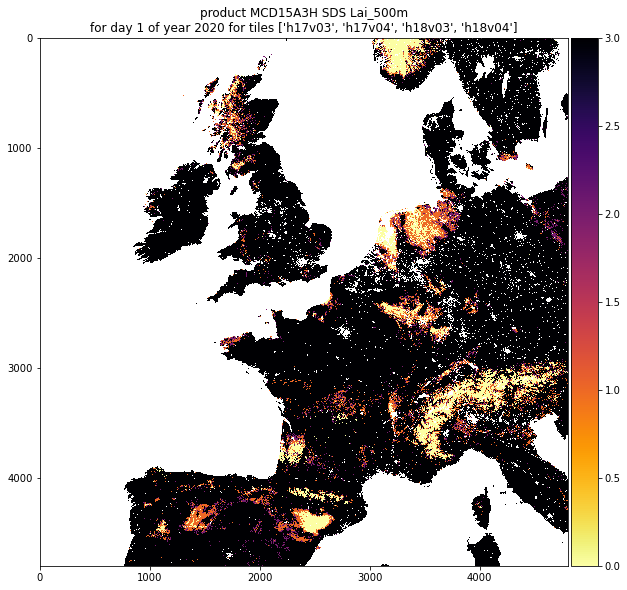

In [21]:
# call visualise
title = 'product {product} SDS {layer}\n'.format(**params) + \
        'for day {doy} of year {year} for tiles {tiles}'.format(**params)
# set the max value to 3.0 to be able to see whats going on
plot=visualise(lai,title=title,vmax=3.0)

# Exercises

### Exercise: change the year and DOY

Using the lines of code above, download and visualise the LAI dataset for a different DOY and year. Remember that it is a 4-day synthesis, so there are only datasets on doy 1,5,9, ...

Put comments in your code using `#` to start a comment, to describe what you are doing.

You might want to set `verbose` to `True` to get some feedback on what is going on.

Testing for MODIS files on this computer ...
Looking at https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.04.30
Tile URLs ['https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.04.30/MCD15A3H.A2020121.h17v03.006.2020126221607.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.04.30/MCD15A3H.A2020121.h17v04.006.2020126222104.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.04.30/MCD15A3H.A2020121.h18v03.006.2020126220839.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.04.30/MCD15A3H.A2020121.h18v04.006.2020126220848.hdf']
MCD15A3H.A2020121.h17v03.006.2020126221607.hdf
data/MCD15A3H.A2020121.h17v03.006.2020126221607.hdf exists
MCD15A3H.A2020121.h17v04.006.2020126222104.hdf
data/MCD15A3H.A2020121.h17v04.006.2020126222104.hdf exists
MCD15A3H.A2020121.h18v03.006.2020126220839.hdf
data/MCD15A3H.A2020121.h18v03.006.2020126220839.hdf exists
MCD15A3H.A2020121.h18v04.006.2020126220848.hdf
data/MCD15A3H.A2020121.h18v04.006.2020126220848.hdf exists
files: [PosixPath('data/

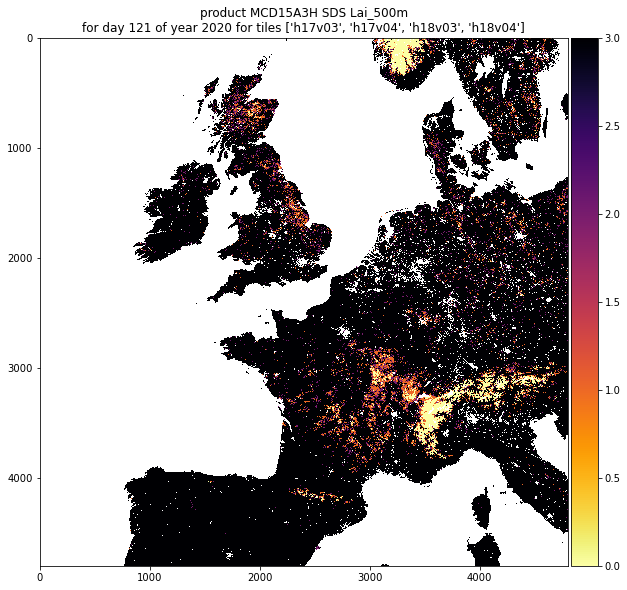

In [32]:
from uclgeog_msc.process_timeseries import mosaic_and_clip, visualise

#######################
# doy = 1 + 4 * 20 here
#######################
params = {
    'tiles'  :    ['h17v03', 'h17v04', 'h18v03', 'h18v04'],
    'doy'    :    1+4*30,
    'year'   :    2020,
    'product':    'MCD15A3H',
    'layer'  :    'Lai_500m',
    'grid'   :    'MOD_Grid_MCD15A3H',
    'verbose':    True
}

#######################
# download and interpret
#######################
# check to see if it worked
# and trap errors 
try:
    lai = mosaic(params)
    assert lai is not None
except:
    print("\nThis hasn't worked")
else:
    lai = lai.astype(float)
    lai[lai>248] = np.nan
    #######################
    # call visualise
    #######################
    title = 'product {product} SDS {layer}\n'.format(**params) + \
            'for day {doy} of year {year} for tiles {tiles}'.format(**params)
    plot=visualise(lai,title=title,vmax=3.0)

### Exercise: change the location

Using the lines of code above, download and visualise the LAI dataset for a different location.

You will need to specify the tile or tiles that you wish to use.

As before, put comments in your code using `#` to start a comment, to describe what you are doing.

You might want to set `verbose` to `True` to get some feedback on what is going on.

Testing for MODIS files on this computer ...
Looking at https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01
Tile URLs ['https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf']
MCD15A3H.A2020001.h22v10.006.2020006034034.hdf
data/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf exists
MCD15A3H.A2020001.h22v11.006.2020006033437.hdf
data/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf exists
files: [PosixPath('data/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf'), PosixPath('data/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf')]
dataset: ['HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf":MOD_Grid_MCD15A3H:Lai_500m', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf":MOD_Grid_MCD15A3H:Lai_500m']
output format MEM
No data value: 255
returning data array


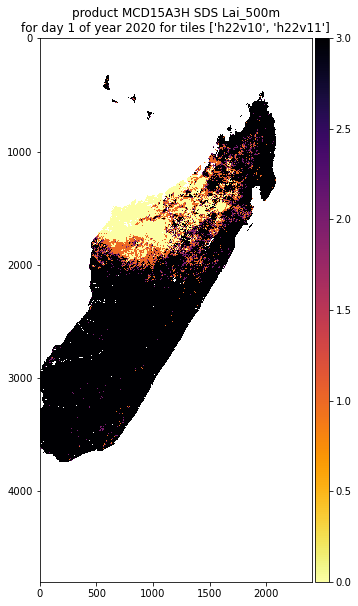

In [23]:
from uclgeog_msc.process_timeseries import mosaic_and_clip, visualise

#######################
# location: madagascar
#######################
params = {
    'tiles'  :    ['h22v10','h22v11'],
    'doy'    :    1,
    'year'   :    2020,
    'product':    'MCD15A3H',
    'grid'   :    'MOD_Grid_MCD15A3H',
    'layer'  :    'Lai_500m',
    'verbose':    True
}

try:
    lai = mosaic(params)
    assert lai is not None
except AssertionError:
    print("\nThis hasn't worked")
else:
    lai = lai.astype(float)
    lai[lai>248] = np.nan
    #######################
    # call visualise
    #######################
    title = 'product {product} SDS {layer}\n'.format(**params) + \
            'for day {doy} of year {year} for tiles {tiles}'.format(**params)
    plot=visualise(lai,title=title,vmax=3.0)

### Exercise: change the SDS

Using the lines of code above, download and visualise the LAI dataset for a different location. 

Now, instead of using the data layer `Lai_500m`, visualise another data layer in the LAI dataset. See the table above of [the product specification](https://lpdaac.usgs.gov/products/mcd15a3hv006/) for details.

Testing for MODIS files on this computer ...
Looking at https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01
Tile URLs ['https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf', 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2020.01.01/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf']
MCD15A3H.A2020001.h22v10.006.2020006034034.hdf
data/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf exists
MCD15A3H.A2020001.h22v11.006.2020006033437.hdf
data/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf exists
files: [PosixPath('data/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf'), PosixPath('data/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf')]
dataset: ['HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h22v10.006.2020006034034.hdf":MOD_Grid_MCD15A3H:FparLai_QC', 'HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2020001.h22v11.006.2020006033437.hdf":MOD_Grid_MCD15A3H:FparLai_QC']
output format MEM
No data value: 255
returning data array


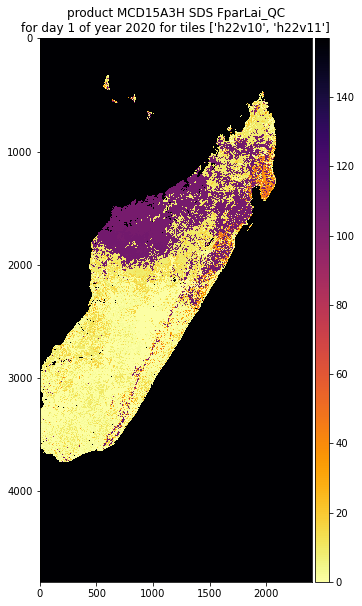

In [41]:
from uclgeog_msc.process_timeseries import mosaic_and_clip, visualise

#######################
# location: madagascar
#######################
params = {
    'tiles'  :    ['h22v10','h22v11'],
    'doy'    :    1,
    'year'   :    2020,
    'product':    'MCD15A3H',
    'grid'   :    'MOD_Grid_MCD15A3H',
    'layer'  :    'FparLai_QC',
    'verbose':    True
}

#######################
# download and interpret
# note the valid range is different
# see the product table above
#######################

try:
    data = mosaic(params)
    assert data is not None
except AssertionError:
    print("\nThis hasn't worked")
else:
    data = data.astype(float)
    data[data>254] = np.nan
    #######################
    # call visualise
    #######################
    title = 'product {product} SDS {layer}\n'.format(**params) + \
            'for day {doy} of year {year} for tiles {tiles}'.format(**params)
    plot=visualise(data,title=title)

### Exercise: change the product to another on MOTA

Using the lines of code above, download and visualise a different MODIS product.

You can see the option codes on the server we have been using by [looking in the directory https://e4ftl01.cr.usgs.gov/MOTA](https://e4ftl01.cr.usgs.gov/MOTA).

You get get the meanings of the codes from simply googling them, or you can look them up on the [MODIS data product page](https://modis.gsfc.nasa.gov/data/dataprod/).

Testing for MODIS files on this computer ...
Looking at https://e4ftl01.cr.usgs.gov/MOTA/MCD64A1.006/2020.01.01
Tile URLs ['https://e4ftl01.cr.usgs.gov/MOTA/MCD64A1.006/2020.01.01/MCD64A1.A2020001.h22v10.006.2020067001750.hdf']
MCD64A1.A2020001.h22v10.006.2020067001750.hdf
data/MCD64A1.A2020001.h22v10.006.2020067001750.hdf exists
files: [PosixPath('data/MCD64A1.A2020001.h22v10.006.2020067001750.hdf')]
dataset: ['HDF4_EOS:EOS_GRID:"data/MCD64A1.A2020001.h22v10.006.2020067001750.hdf":MOD_Grid_Monthly_500m_DB_BA:Burn Date']
output format MEM
No data value: 255
returning data array


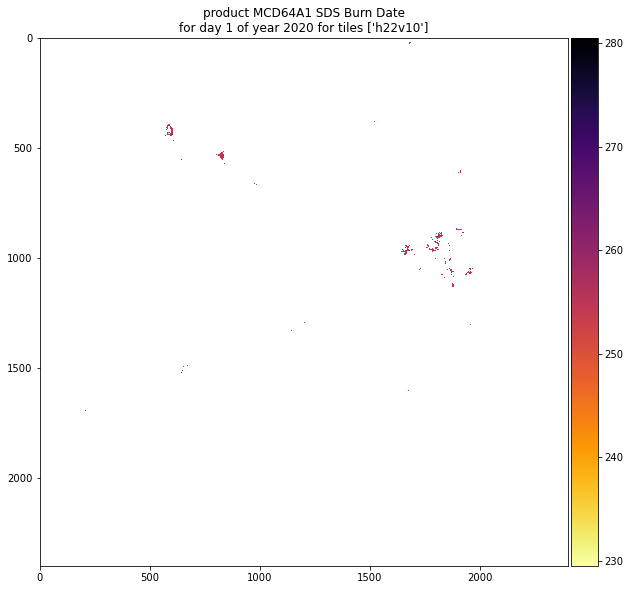

In [43]:
from uclgeog_msc.process_timeseries import mosaic_and_clip, visualise

#######################
# location: madagascar
# product MCD64A1 Burned Area
# see product page on
# https://lpdaac.usgs.gov/products/mcd64a1v006/
# we see one of the SDS layers is 'Burn Date'
# and that 1 to 366 are valid
#
# get the grid from 
# https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MCD64A1
#######################
params = {
    'tiles'  :    ['h22v10'],
    'doy'    :    1,
    'year'   :    2020,
    'product':    'MCD64A1',
    'layer'  :    'Burn Date',
    'grid'   :    'MOD_Grid_Monthly_500m_DB_BA',
    'verbose':    True
}

#######################
# download and interpret
# note the valid range is different
# see the product table above
# Use a different variable name: 
# its not lai any more!
#######################
try:
    data = mosaic(params)
    assert data is not None
except:
    print("\nThis hasn't worked")
else:
    data = data.astype(float)
    data[data>366] = np.nan
    data[data<1] = np.nan
    #######################
    # call visualise
    #######################
    title = 'product {product} SDS {layer}\n'.format(**params) + \
            'for day {doy} of year {year} for tiles {tiles}'.format(**params)
    plot=visualise(data,title=title)

### Exercise: try another 
Using the lines of code above, download and visualise a different MODIS product.

Testing for MODIS files on this computer ...
Looking at https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/2018.01.01
Tile URLs ['https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/2018.01.01/MCD12Q1.A2018001.h22v10.006.2019199230150.hdf']
MCD12Q1.A2018001.h22v10.006.2019199230150.hdf
data/MCD12Q1.A2018001.h22v10.006.2019199230150.hdf exists
files: [PosixPath('data/MCD12Q1.A2018001.h22v10.006.2019199230150.hdf')]
dataset: ['HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2018001.h22v10.006.2019199230150.hdf":MCD12Q1:LC_Type1']
output format MEM
No data value: 255
returning data array


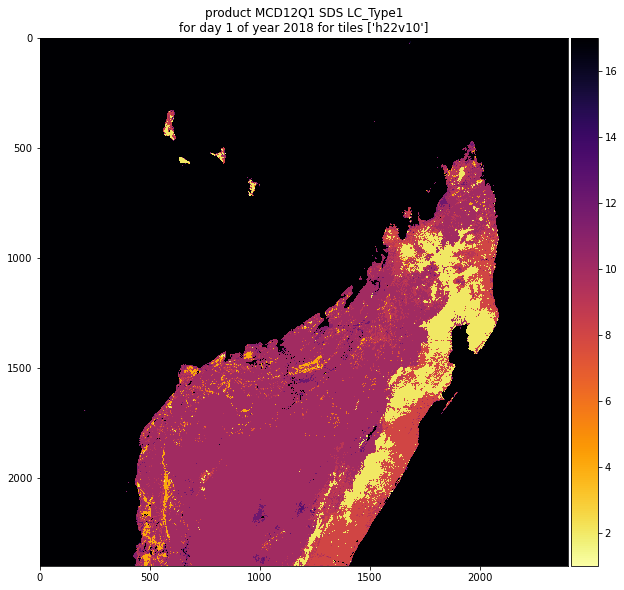

In [44]:
from uclgeog_msc.process_timeseries import mosaic_and_clip, visualise

#######################
# location: madagascar
# product MCD12C1 yearly Land cover
# see product page on
# https://lpdaac.usgs.gov/products/mcd12q1v006/
# we see one of the SDS layers is 'Majority_Land_Cover_Type_1'
# and that 255 is invalid
#
# get the grid from 
# https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MCD12Q1
#
# Note that date for dataset is 2001.01.01
# from https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/
# year 2019 & 2020 not there yet!!
#######################
params = {
    'tiles'  :    ['h22v10'],
    'doy'    :    1,
    'year'   :    2018,
    'product':    'MCD12Q1',
    'layer'  :    'LC_Type1',
    'grid'   :    None,
    'verbose':    True
}

#######################
# download and interpret
# note the valid range is different
# see the product table above
# Use a different variable name: 
# its not lai any more!
#######################
try:
    data = mosaic(params)
    assert data is not None
except:
    print("\nThis hasn't worked")
else:
    data = data.astype(float)
    data[data>254] = np.nan
    #######################
    # call visualise
    #######################
    title = 'product {product} SDS {layer}\n'.format(**params) + \
            'for day {doy} of year {year} for tiles {tiles}'.format(**params)
    plot=visualise(data,title=title)

In [ ]:
from uclgeog_msc.process_timeseries import mosaic_and_clip, visualise

#############
# FparLai_QC
#############

#######################
# single tile here
# for SDS FparLai_QC
# note that valid values different here
#######################
params = {
    'tiles'  :    ['h18v03'],
    'doy'    :    1+4*30,
    'year'   :    2020,
    'product':    'MCD15A3H',
    'layer'  :    'FparLai_QC',
    'verbose':    True
}

#######################
# download and interpret
#######################
lai = mosaic_and_clip(**params).astype(float)
lai[lai>254] = np.nan
#######################
# call visualise
# Don't' set vmax now 
# as we want to see the 
# full range of values
#######################
title = 'product {product} SDS {layer}\n'.format(**params) + \
        'for day {doy} of year {year} for tiles {tiles}'.format(**params)
plot=visualise(lai,title=title)

# Summary

In these notes, we have introduced the characteristics of MODIS data products, and learned how to specify, access, and display them.

You should spend some time going through the various links to explore the different datasets, and try out the exercises above for various products. The familiarity you gain from this will help when it comes to building our own codes later on.